# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Описание данных:**

<table align='left'>
    <tr><td><i>children</i></td><td>количество детей в семье</td></tr>
    <tr><td><i>days_employed</i></td><td>общий трудовой стаж в днях</td></tr>
    <tr><td><i>dob_years</i></td><td>возраст клиента в годах</td></tr>
    <tr><td><i>education</i></td><td>уровень образования клиента</td></tr>
    <tr><td><i>education_id</i></td><td>идентификатор уровня образования</td></tr>
    <tr><td><i>family_status</i></td><td>семейное положение</td></tr>
    <tr><td><i>family_status_id</i></td><td>идентификатор семейного положения</td></tr>
    <tr><td><i>gender</i></td><td>пол клиента</td></tr>
    <tr><td><i>income_type</i></td><td>тип занятости</td></tr>
    <tr><td><i>debt</i></td><td>имел ли задолженность по возврату кредитов</td></tr>
    <tr><td><i>total_income</i></td><td>ежемесячный доход</td></tr>
    <tr><td><i>purpose</i></td><td>цель получения кредита</td></tr>
</table>

## Загрузка данных

Импортируем библиотеку pandas и сохраним CSV-файл в переменную *data*.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from collections import Counter

In [53]:
data = pd.read_csv('datasets/data.csv')

Проверим корректность загрузки данных и изучим общую информацию о таблице. 

In [54]:
data.head(8)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Таблица с клиентами содержит 21525 записей. В столбцах *days_employed*, *total_income* имеются пропуски данных. Также можно заметить, что столбец *days_employed* содержит некорректные данные. Рассмотрим столбец *days_employed* - определим некоторые статистики этого столбца:

In [56]:
overemployed_clients = data[data['days_employed'] > (data['dob_years'] * 365)]['days_employed'].count()

print('Число клиентов со стажем больше их возраста:', overemployed_clients)
print('Процент некорректных данных по числу дней занятости: {:.1%}'.format(overemployed_clients / data.shape[0]))

Число клиентов со стажем больше их возраста: 3445
Процент некорректных данных по числу дней занятости: 16.0%


**Вывод**

Всего в таблице 21525 строк. Из общей информации и первых строк таблицы видно, что:

* В столбцах *days_employed* и *total_income* отсутствуют значения, причем число таких значений одинаково.

* Значения столбца *days_employed* представляют собой отрицательные числа и числа, которые заведомо не могут быть верными (340266 дней ~ 932 года). Можно предположить, что отрицательные значения следует взять по модулю, тогда они будут отражать истинные значения.

* Значения в *education* представлены в разном регистре.

* Тип данных в столбце *total_income* приведем к целочисленному.

* Столбцы *family_status* - *family_status_id*, *education* - *education_id* обозначают статус клиента и идентификатор статуса. Столбец с текстовым содержанием статуса выделим в отдельный словарь.

* Столбец *purpose* имеет значения совпадающие по смыслу, но записанные разными словами и их формами. Обобщим список целей.

Таблица с данными клиентов банка имеет все данные для решения поставленной задачи. Значения таблицы необходимо привести к нужному типу данных, заполнить пропуски. Некоторые столбцы нужно вывести в отдельные словари.

## Предобработка данных

### Обработка пропусков

Исследуем пропуски в таблице данных.

In [57]:
missing_values = pd.DataFrame(data=data.isna().sum(), columns=['count'])
missing_values['percent'] = round(missing_values['count'] / data.shape[0] * 100, 2)
missing_values[missing_values['count'] > 0]

,count,percent
days_employed,2174,10.1
total_income,2174,10.1


In [58]:
print('Число строк с пропусками в обоих столбцах:', 
      data[data['days_employed'].isnull() & data['total_income'].isnull()].shape[0])

data[data['days_employed'].isna()].head(5)

Число строк с пропусками в обоих столбцах: 2174


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Доля пропусков в столбцах *total_income* и *days_employed* составляет около 10% от всего набора данных. Пропуски в обои столбцах наблюдаются в одних и тех же строках. Можно попробовать восстановить пропущенные данные по другим имеющимся. Строки в которых отсутсвуют сведения о доходах клиентов имеют информацию о типе занятости. Попробуем восстановить информацию о доходах по этому признаку.

#### Работа со столбцом *income_type*

Найдем медианные значения доходов клиентов по каждому типу занятости. И заменим значения NaN в столбце *total_income* на медиану, соответствующую значению в *income_type*. 

In [59]:
income_types_grouped = data.groupby('income_type')['total_income'].median()
income_types_list = data['income_type'].unique()
print('Медианное значение дохода для различных групп занятости:', income_types_grouped.sort_values(ascending=False))

Медианное значение дохода для различных групп занятости: income_type
предприниматель    499163.144947
компаньон          172357.950966
госслужащий        150447.935283
сотрудник          142594.396847
безработный        131339.751676
пенсионер          118514.486412
студент             98201.625314
в декрете           53829.130729
Name: total_income, dtype: float64


In [60]:
for income_type in income_types_list:
    data.loc[data['income_type'] == income_type, 'total_income'] = \
    data['total_income'].fillna(income_types_grouped[income_type])

Проверим информацию о таблице и убедимся, что пропуски заполнены.

In [61]:
missing_values = pd.DataFrame(data=data.isna().sum(), columns=['count'])
missing_values.loc[['days_employed', 'total_income']]

,count
days_employed,2174
total_income,0


Возможная причина отсутствия значений это - непредоставление заемщиком сведений о доходах в банк.

#### Работа со столбцом *days_employed*

Исследуем значения столбца *days_employed*. Возьмем значения дней по модулю и проверим описание распределения дней в таблице.

In [62]:
data['days_employed'] = data['days_employed'].apply(abs)
data['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

Среднее значение больше медианного примерно в 30 раз.

In [63]:
print('Медиана: ~', data['days_employed'].median() // 365, 'лет')
print('Среднее: ~', data['days_employed'].mean() // 365, 'лет')

Медиана: ~ 6.0 лет
Среднее: ~ 183.0 лет


Построим график распределения значений столбца.

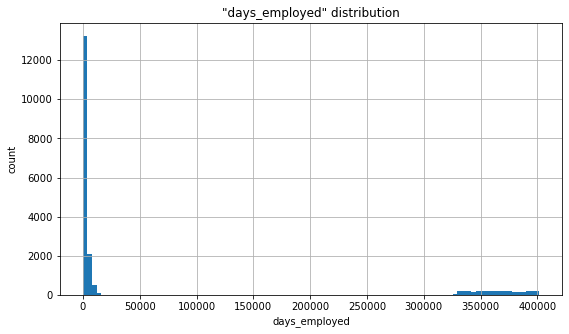

In [64]:
fig = plt.figure(figsize=(9, 5))
plt.hist(data['days_employed'], bins=100)
plt.xlabel('days_employed')
plt.ylabel('count')
plt.title('"days_employed" distribution')
plt.grid()
plt.show()

На графике распределения обнаружены две группы значений. "Правая", начинающаяся примерно от 320,000 явно аномальная. Исходя из порядка разницы между значениями, можно сделать предположение, что "аномальные" значения выражены в часах. 

In [65]:
data[data['days_employed'] > 18000].sort_values(by='days_employed').head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
16335,1,18388.949901,61,среднее,1,женат / замужем,0,F,сотрудник,0,186178.934089,операции с недвижимостью
20444,0,328728.720605,72,среднее,1,вдовец / вдова,2,F,пенсионер,0,96519.339647,покупка жилья для семьи
9328,2,328734.923996,41,высшее,0,женат / замужем,0,M,пенсионер,0,126997.497760,операции со своей недвижимостью
17782,0,328771.341387,56,среднее,1,женат / замужем,0,F,пенсионер,0,68648.047062,операции с коммерческой недвижимостью
14783,0,328795.726728,62,высшее,0,женат / замужем,0,F,пенсионер,0,79940.196752,на покупку своего автомобиля


Конвертируем аномальные значения в дни, разделив на 24. 

In [66]:
normal_max = 20000  # обозначим 20,000 как максимальное нормальное значение
data['days_employed'] = data.days_employed.apply(lambda i: i if i <= normal_max else i / 24)

В столбце *days_employed* также отсутствуют некоторые значения. Заменим отсутствующие на средние взяв их по возрасту.

In [67]:
d_emp_mean_by_age = data.groupby('dob_years')['days_employed'].mean()

In [68]:
def nan_to_mean(row):
    days_employed = row['days_employed']
    age = row['dob_years']
    
    if (days_employed > age * 365) or pd.isnull(days_employed):
        return d_emp_mean_by_age[age]
    return days_employed

In [69]:
data['days_employed'] = data.apply(nan_to_mean, axis=1)

Проверим остались ли пропуски в таблице data.

In [70]:
pd.DataFrame(data.isnull().sum(), columns=['count'])

,count
children,0
days_employed,0
dob_years,0
education,0
education_id,0
family_status,0
family_status_id,0
gender,0
income_type,0
debt,0


#### Преобразования столбца *dob_years*

Просмотрим значения столбца.

In [71]:
data['dob_years'].describe()

count    21525.000000
mean        43.293380
std         12.574584
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

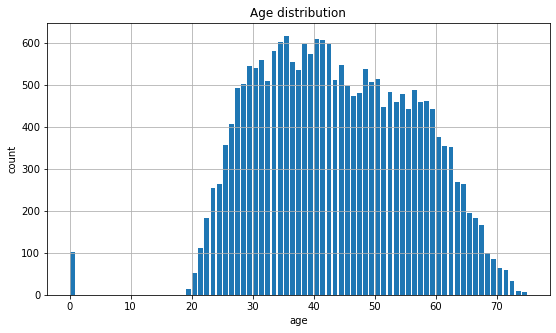

In [72]:
fig = plt.figure(figsize=(9, 5))
plt.hist(data['dob_years'], bins=75, rwidth=0.8)
plt.title('Age distribution')
plt.xlabel('age')
plt.ylabel('count')
plt.grid()
plt.show()

Возраст некоторых клиентов оказался равен нулю. Заполним нули средним возрастом по типу дохода.

In [73]:
age_mean = data[data['dob_years'] > 0].groupby('income_type')['dob_years'].mean()
age_mean

income_type
безработный        38.000000
в декрете          39.000000
госслужащий        40.804542
компаньон          39.854294
пенсионер          59.370959
предприниматель    42.500000
сотрудник          40.018980
студент            22.000000
Name: dob_years, dtype: float64

Тип дохода достаточно хорошо отражает возраст клиента. Применим функцию для замены нулей средним значением.

In [74]:
def zero_to_mean(row):
    if row['dob_years'] == 0:
        return int(age_mean[row['income_type']])
    return row['dob_years']

In [75]:
data['dob_years'] = data.apply(zero_to_mean, axis=1)

Проверим еще раз условие неравенства общего стажа и возраста клиента.

In [76]:
print('Число значений больше возраста:', data[data['days_employed'] > (data['dob_years'] * 365)]['days_employed'].count())

Число значений больше возраста: 0


#### Проверка значений в столбце *children*

In [77]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Сразу заметны два аномальных значения: 20 и -1. В сумме эти значения составляют около 0,5% от общего числа значений. Можно предположить, что 20 это ошибочная запись 2, а -1 это ошибочная запись 1. Заменим аномальные величины на соответствующие им.

In [78]:
data['children'] = data['children'].replace(20, 2)
data['children'] = data['children'].replace(-1, 1)

data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

### Замена типа данных

In [79]:
data.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Столбец *total_income* представлен вещественным типом данных. Доли от единицы не отражают доходы клиентов банка. Тип данных в этом столбце заменим на целочисленный.

In [80]:
data['total_income'] = data['total_income'].astype('int')
data['total_income'].dtypes

dtype('int32')

Также заменим тип данных в столбце *days_employed* на целочисленный.

In [81]:
data['days_employed'] = data['days_employed'].astype('int')
data['days_employed'].dtypes

dtype('int32')

### Обработка дубликатов

Прежде чем искать дубликаты, необходимо привести значения в столбце *education* к нижнему регистру.

In [82]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Проверим наличие дубликатов в таблице.

In [83]:
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 71


Удалим обнаруженные дубликаты методом .drop_duplicates() и проверим исполнение метода.

In [84]:
data = data.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


### Обработка столбца *purpose*

В столбце *purpose* содержится информация о цели кредита. Для разных записей одна и та же по смыслу цель может быть записана по разному. Определим список целей кредита и приведем значения *purpose* к значениям списка.

Воспользуемся библиотекой pymystem3 и лемматизируем значения в *purpose*. Лемматизация - процесс, в результате которого будет получен список изначальных форм каждого слова в предложении.

Библиотека pymystem3 отличается большим временем инициализации функции лемматизации. Чтобы максимально сократить время процесса, объединим все значения столбца *purpose* в одну строку, но разделим значения для разных объектов значением "br". Одновременно создадим переменную типа Counter, в которой посчитаем количество появлений каждого слова.

In [85]:
m = Mystem()
purpose_lemmas = m.lemmatize(' br '.join(data['purpose'].values))

purpose = [[]]
purpose_count = Counter()
stop_words = ('с', 'на', 'со', 'для')

for word in purpose_lemmas[::2]:
    if word == 'br':
        purpose.append([])
    elif word not in stop_words:
        purpose[-1].append(word)
        purpose_count += Counter([word])

# Присвоим лемматизированые значения
data['purpose'] = purpose

Покажем 10 самых употребляемых слов.

In [86]:
purpose_count.most_common(10)

[('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('строительство', 1878),
 ('высокий', 1374)]

Из списка выше можно определить список целей, которые указывают клиенты.

In [87]:
general_purpose_list = {'недвижимость', 'жилье', 'автомобиль', 'образование', 'свадьба'}

Заменим леммы в столбце *purpose* на одно из значений списка целей. Заметим, что цели "недвижимость" и "жилье" являются одним и тем же, значение "жилье" можно заменить на "недвижимость".

In [88]:
def lemmas_to_category(row):
    purpose = set(row['purpose']).intersection(general_purpose_list).pop()
    if purpose == 'жилье':
        purpose = 'недвижимость'
    return purpose

In [89]:
data['purpose'] = data.apply(lemmas_to_category, axis=1)
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,свадьба


Проверим, что все строки имеют одну из целей в нашем списке.

In [90]:
data['purpose'].value_counts()

недвижимость    10811
автомобиль       4306
образование      4013
свадьба          2324
Name: purpose, dtype: int64

**Вывод**

Столбец *purpose* лемматизирован. Из лемматизированных списков удалось выявить разделение целей кредита на 4 категории: недвижимость, автомобиль, образование и свадьба. 

### Категоризация данных

#### *education*, *family_status*, *income_type*, *purpose*

Выделим словарь для значений *education*

In [91]:
education_dict = data[['education_id', 'education']].drop_duplicates().reset_index(drop=True)
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Выделим словарь для значений *family_status*

In [92]:
family_status_dict = data[['family_status_id', 'family_status']].drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Выделим словарь для значений *income_type*

In [93]:
df_dict = {'income_type_id': list(range(data['income_type'].value_counts().shape[0])),
           'income_type': data['income_type'].value_counts().index}
income_type_dict = pd.DataFrame(df_dict)
income_type_dict

,income_type_id,income_type
0,0,сотрудник
1,1,компаньон
2,2,пенсионер
3,3,госслужащий
4,4,предприниматель
5,5,безработный
6,6,в декрете
7,7,студент


Выделим словарь для значений *purpose*

In [94]:
general_purpose_list

{'автомобиль', 'жилье', 'недвижимость', 'образование', 'свадьба'}

In [95]:
general_purpose_list.remove('жилье')
df_dict = {'purpose_id':[0, 1, 2, 3], 'purpose':list(general_purpose_list)}
purpose_dict = pd.DataFrame(df_dict)
purpose_dict

,purpose_id,purpose
0,0,автомобиль
1,1,образование
2,2,недвижимость
3,3,свадьба


#### *total_income*

Исследуем значения *total_income*.

count    2.145400e+04
mean     1.653196e+05
std      9.818730e+04
min      2.066700e+04
25%      1.076230e+05
50%      1.425940e+05
75%      1.958202e+05
max      2.265604e+06
Name: total_income, dtype: float64

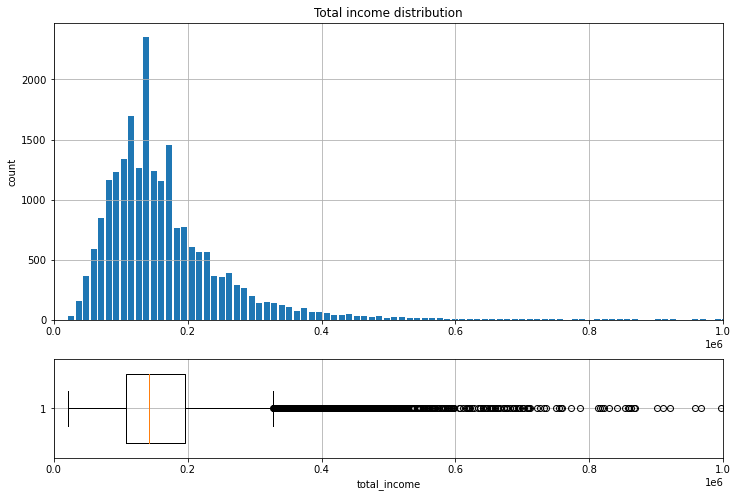

In [96]:
display(data['total_income'].describe())

fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw=dict(height_ratios=[3, 1]))

ax[0].hist(data['total_income'], bins=200, rwidth=0.8)
ax[0].grid()
ax[0].set_xlim(0, 1e6)
ax[0].set_title('Total income distribution')
ax[0].set_ylabel('count')

ax[1].boxplot(data['total_income'], vert=False, widths=0.7)
ax[1].grid()
ax[1].set_xlim(0, 1e6)
ax[1].set_xlabel('total_income')

plt.show()

Разделим доход клиентов на четыре группы и напишем  функцию, которая определит группу для каждого клиента по его доходу. 

In [97]:
income_list = ['до 100000', 'от 100 до 200 тыс.', 'от 200 до 400 тыс.', 'больше 400 тыс.']

def income_category(row):
    income = row['total_income']
    
    if income > 400000:
        return income_list[3]
    
    elif income > 200000:
        return income_list[2]
    
    elif income > 100000:
        return income_list[1]
    
    elif income > 0:
        return income_list[0]

data['income_status'] = data.apply(income_category, axis=1)

df_dict = {'income_status_id':[0, 1, 2, 3], 'income_status':income_list}
income_dict = pd.DataFrame(df_dict)
income_dict

,income_status_id,income_status
0,0,до 100000
1,1,от 100 до 200 тыс.
2,2,от 200 до 400 тыс.
3,3,больше 400 тыс.


In [98]:
data['income_status'].value_counts()

от 100 до 200 тыс.    11924
от 200 до 400 тыс.     4538
до 100000              4463
больше 400 тыс.         529
Name: income_status, dtype: int64

In [99]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_status
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,недвижимость,от 200 до 400 тыс.
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,автомобиль,от 100 до 200 тыс.
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,недвижимость,от 100 до 200 тыс.
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,образование,от 200 до 400 тыс.
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,свадьба,от 100 до 200 тыс.


Добавим идентификаторы дохода клиента, цели кредита и типа занятости *income_status_id*  в таблицу *data*.

In [100]:
data = data.merge(income_dict, on='income_status', how='left')
data = data.merge(purpose_dict, on='purpose', how='left')
data = data.merge(income_type_dict, on='income_type', how='left')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_status,income_status_id,purpose_id,income_type_id
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,недвижимость,от 200 до 400 тыс.,2,2,0
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,автомобиль,от 100 до 200 тыс.,1,0,0
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,недвижимость,от 100 до 200 тыс.,1,2,0
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,образование,от 200 до 400 тыс.,2,1,0
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,свадьба,от 100 до 200 тыс.,1,3,2


Удалим из таблицы столбцы, дублирующие словари.

In [101]:
data.drop(['education', 'family_status', 'purpose', 'income_status', 'income_type'], axis=1, inplace=True)

In [102]:
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,debt,total_income,income_status_id,purpose_id,income_type_id
0,1,8437,42,0,0,F,0,253875,2,2,0
1,1,4024,36,1,0,F,0,112080,1,0,0
2,0,5623,33,1,0,M,0,145885,1,2,0
3,3,4124,32,1,0,M,0,267628,2,1,0
4,0,14177,53,1,1,F,0,158616,1,3,2


**Вывод**

Предобработка данных завершена, можно переходить к ответам на поставленные вопросы, используя преобразованные данные.
Были проведены следующие операции:

- исключены дубликаты строк;
- заполнены пропуски "востановленными" значениями;
- приведены типы данных к удобным для анализа;
- категориальные значения выделены в отдельные словари и в таблице заменены на числовые значения. 

## Ответьте на вопросы

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Составим сводную таблицу по столбцам *children* и *debt*. Сгруппируем по числу детей заемщика и посчитаем процент и количество должников по каждой группе.

In [103]:
data.pivot_table(index='children', values='debt', aggfunc=['mean', 'count'])\
    .sort_values(by=('mean', 'debt'), ascending=False)\
    .style.format({('mean', 'debt'):'{:.2%}'})

,mean,count
,debt,debt
children,,
4,9.76%,41
2,9.49%,2128
1,9.17%,4855
3,8.18%,330
0,7.54%,14091
5,0.00%,9


**Ответ**

Минимальный процент невозвратных кредитов имеется у клиентов без детей. Далее по мере __увеличения количества детей процент задолженностей растет__. Из общей тенденции выделяется выборка клиентов с тремя детьми, показатель задолженности несколько ниже, чем у клиентов с двумя и четыремя детьми. Выборка клиентов с пятью детьми представлена девятью записями для анализа зависимости это слишком малое число.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Составим сводную таблицу по столбцам *family_status* и *debt*. Сгруппируем по статусу заемщика и посчитаем процент и количество должников по каждой группе.

In [112]:
data.merge(family_status_dict, on='family_status_id', how='left')\
    .pivot_table(index='family_status', values='debt', aggfunc=['mean', 'count'])\
    .sort_values(by=('mean', 'debt'), ascending=False)\
    .style.format({('mean', 'debt'):'{:.2%}'})

,mean,count
,debt,debt
family_status,,
Не женат / не замужем,9.75%,2810
гражданский брак,9.35%,4151
женат / замужем,7.55%,12339
в разводе,7.11%,1195
вдовец / вдова,6.57%,959


**Ответ**

Среди клиентов никогда не регистрировавших брак - "не женат/не замужем", "гражданский брак" - прослеживается больший процент задолженности по кредиту - 9.75 и 9.35 процентов соответственно. Среди заемщиков заключавших брак ранее процент невозврата кредита меньше 6.57 - 7.55 %. Самый низкий показатель у "вдовцов/вдов", частично, можно объяснить малой выборкой, а высокую надежность клиентов находящихся в браке более высокой ответственностью заемщика, а также возможностью отдавать кредит супругам вместе.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Составим сводную таблицу по столбцам *income_status* и *debt*. Сгруппируем по доходу заемщика и посчитаем процент и количество должников по каждой группе.

In [115]:
data.merge(income_dict, on='income_status_id', how='left')\
    .pivot_table(index='income_status', values='debt', aggfunc=['mean', 'count'])\
    .sort_values(by=('mean', 'debt'), ascending=False)\
    .style.format({('mean', 'debt'):'{:.2%}'})

,mean,count
,debt,debt
income_status,,
от 100 до 200 тыс.,8.63%,11924
до 100000,7.93%,4463
от 200 до 400 тыс.,7.21%,4538
больше 400 тыс.,5.86%,529


**Ответ**

Наибольшей надежностью отличаются заемщики с доходами в категориях от 200 тыс. и выше (7.03%, 7.15%). Больший процент невозврата в категории до 100 тыс. (7.93%). Максимальный процент задолжнности у клиентов, чьи доходы от 100 до 200 тыс. Эта категория клиентов оказалась самой активной. 

### Как разные цели кредита влияют на его возврат в срок?

Составим сводную таблицу по столбцам *purpose* и *debt*. Сгруппируем по цели кредита и посчитаем процент и количество должников по каждой группе.

In [116]:
data.merge(purpose_dict, on='purpose_id', how='left')\
    .pivot_table(index='purpose', values='debt', aggfunc=['mean', 'count'])\
    .sort_values(by=('mean', 'debt'), ascending=False)\
    .style.format({('mean', 'debt'):'{:.2%}'})

,mean,count
,debt,debt
purpose,,
автомобиль,9.36%,4306
образование,9.22%,4013
свадьба,8.00%,2324
недвижимость,7.23%,10811


**Ответ**

Самый низкий процент долга по кредиту при цели кредита "жилье" (7.23%). Немного менее надежны выданные кредиты на свадьбу (8%). Наибольший процент долга у кредитов с целями "автомобиль" и "образование" (9.36% и 9.22%). 

Надежность кредитов с целями "свадьба" можно объяснить тем, что такой кредит берут клиенты вступающие в брак, а значит имеющие больше шансов успешно вернуть кредит, если расплачиваются за него супруги вместе. Похожие причины можно указать и для кредитов с целью "жилье".

## Общий вывод

Проведено исследование клиентов банка. По результатам этого исследования были установленны зависимости надежности заемщиков от ряда параметров - количество детей, семейное положение, общий доход и цель кредита. 

В частности было установлено, что наиболее надежны заемщики без детей, а с увеличением их числа увеличивается процент должников по кредиту. Семейное положение тоже влияет на надежность клиента - более надежны заемщики назодящиеся или когда-либо находившиеся в браке. В зависмости от дохода заемщика - надежность увелиивается с увеличением дохода клиента. Наибольший процент долгов по кредиту в категории от 100 до 200 тыс. И наиболее рисковые кредиты выдают на цели "автомобиль" и "образование".

Представленные данные можно использовать для дальнейших исследований и построения моделей кредитного скоринга.